In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Add, LayerNormalization, MultiHeadAttention, Dense, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_and_preprocess_images(folder, target_size=(128, 128)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images and labels
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/")
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/")

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Reshape for the neural network (e.g., adding channel dimension for grayscale images)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Define metrics
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true_f * y_pred_f))
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    smooth = 1.0
    return (intersection + smooth) / (union + smooth)

def precision(y_true, y_pred):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

# Define UNETR model
def unetr_model(input_size=(128, 128, 1), num_heads=2, transformer_layers=2, embedding_dim=32):
    inputs = Input(input_size)
    
    # Initial Convolutional Block
    c1 = Conv2D(embedding_dim, 3, activation='relu', padding='same')(inputs)
    
    # Transformer Encoder Blocks
    x = tf.keras.layers.Reshape((input_size[0] * input_size[1], embedding_dim))(c1)
    for i in range(transformer_layers):
        x1 = LayerNormalization(name=f'layer_norm_{i}_1')(x)
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, name=f'attn_{i}')(x1, x1)
        x2 = Add(name=f'add_{i}_1')([x1, attn_output])
        x3 = LayerNormalization(name=f'layer_norm_{i}_2')(x2)
        ffn_output = Dense(embedding_dim, activation='relu', name=f'ffn_{i}')(x3)
        x = Add(name=f'add_{i}_2')([x2, ffn_output])
    x = tf.keras.layers.Reshape((input_size[0], input_size[1], embedding_dim))(x)
    
    # Decoder Block
    u1 = UpSampling2D(size=(2, 2))(x)
    u1 = Conv2D(embedding_dim // 2, 3, activation='relu', padding='same')(u1)
    
    u2 = Conv2D(embedding_dim // 4, 3, activation='relu', padding='same')(u1)
    u2 = UpSampling2D(size=(2, 2))(u2)
    
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(u2)

    # Ensure the final output shape matches the input shape
    if outputs.shape[1] != input_size[0] or outputs.shape[2] != input_size[1]:
        final_outputs = Cropping2D(cropping=((0, max(0, outputs.shape[1] - input_size[0])), 
                                              (0, max(0, outputs.shape[2] - input_size[1]))))(outputs)
    else:
        final_outputs = outputs

    model = Model(inputs, final_outputs)
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', dice_coefficient, iou, precision, recall, f1_score])
    
    return model

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Instantiate and compile the model
model = unetr_model()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10, 
                    batch_size=2,  # Reduce the batch size
                    verbose=1,
                    callbacks=[early_stopping])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("unetr_model.h5")
print("Model saved as unetr_model.h5")


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Epoch 1/10


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU

# Define custom functions to calculate IoU and Dice coefficient
def mean_iou(y_true, y_pred):
    iou = MeanIoU(num_classes=2)
    iou.update_state(y_true, y_pred)
    return iou.result().numpy()

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)



# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
y_pred = model.predict(X_val)

# Binarize predictions
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate additional evaluation metrics
precision = precision_score(y_val.flatten(), y_pred_binary.flatten())
recall = recall_score(y_val.flatten(), y_pred_binary.flatten())
f1 = f1_score(y_val.flatten(), y_pred_binary.flatten())
iou = mean_iou(y_val, y_pred_binary)
dice = dice_coefficient(y_val, y_pred_binary)

print("Evaluation Metrics:")
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("IoU:", iou)
print("Mean Dice Coefficient:", dice)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8290 - loss: 0.4964
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Evaluation Metrics:
Loss: 0.4963671565055847
Accuracy: 0.8289993405342102
Precision: 0.7496970639329144
Recall: 0.9373217272389047
F1 Score: 0.8330758976115824
IoU: 0.70781386
Mean Dice Coefficient: 0.8330758976115824


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


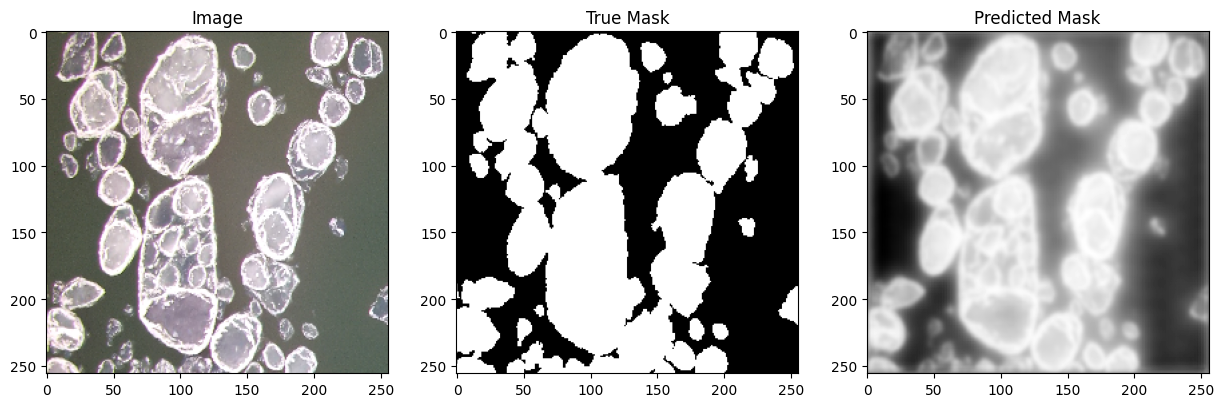

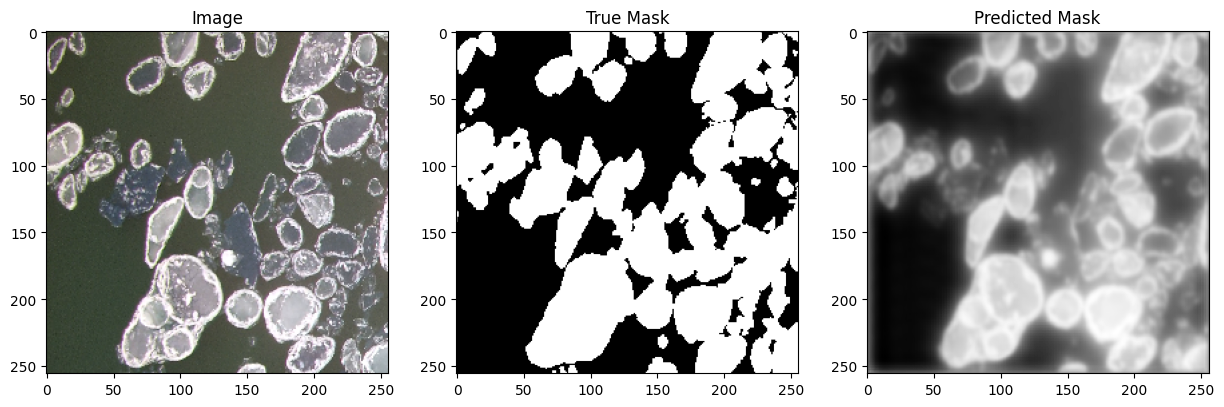

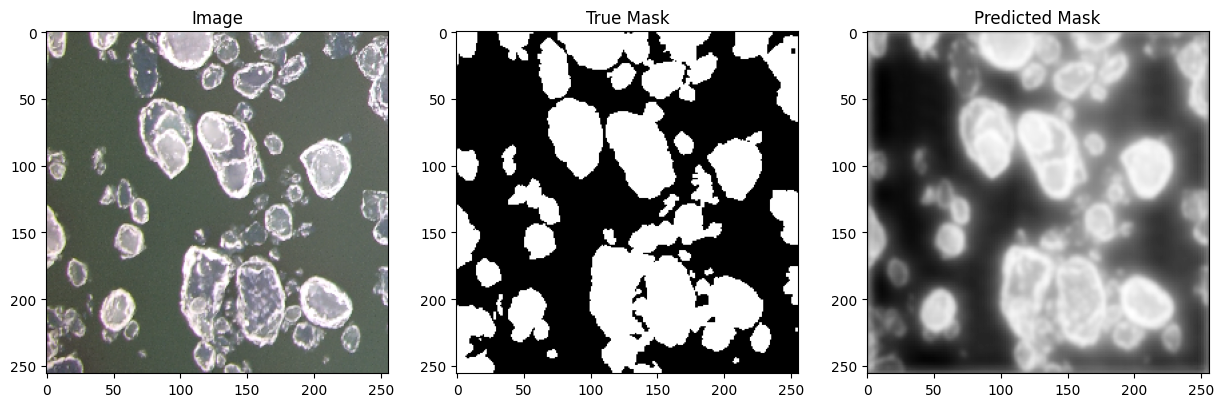

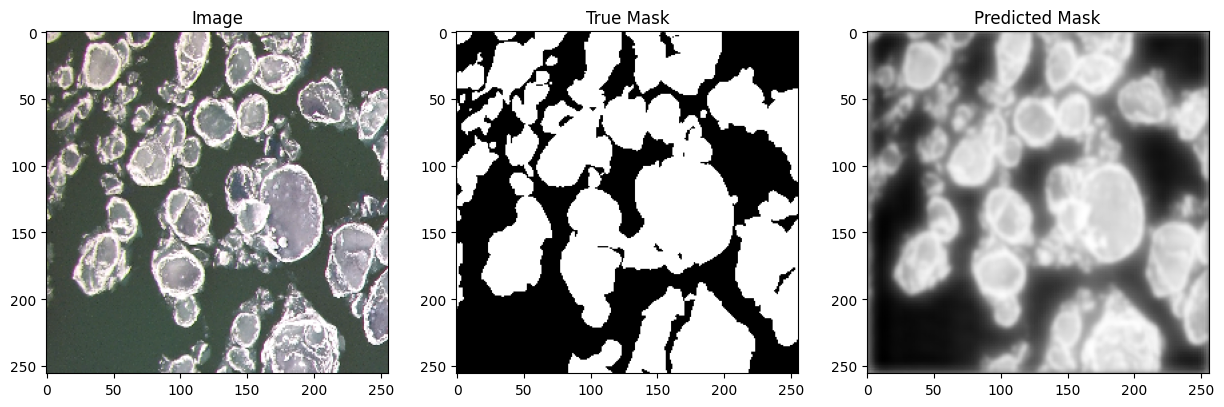

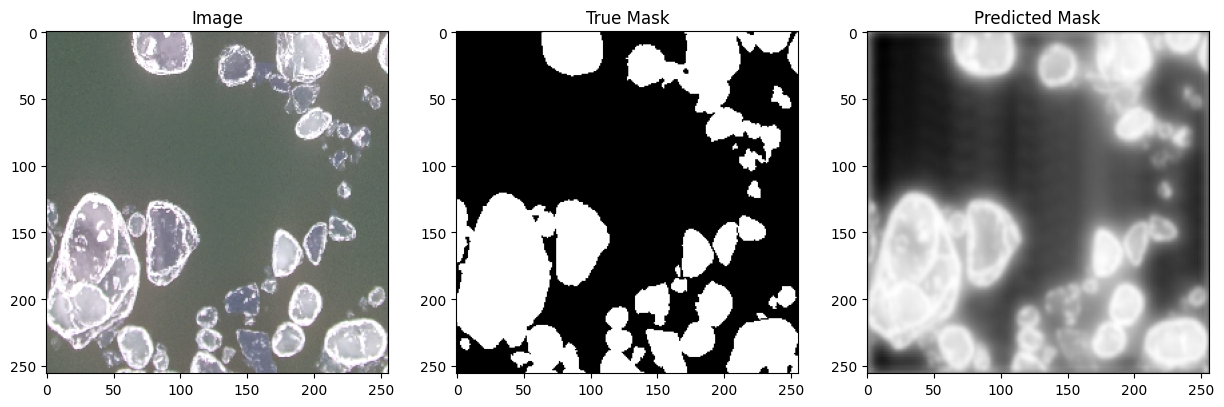

In [ ]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])